# Multilayer Perceptron for Optical Character Recognition

Amitesh Sahu 21074006 

Rituraj Barai 21074024

Soustab Haldar 21074029


# Importing Libraries

In [66]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from PIL import Image
from sklearn.model_selection import train_test_split

## Load data
One of the first steps when working with a new data set is preprocessing.  Our data here is from our dataset  of `28x28` black & white pixel images of handwritten preprocessed lowercase letters from `a-z`.
The dataset is in the form of folders for each of the alphabet where the folder name is the label for an image. For MLP, the image data has to be converted into numerical sing pillow library and python lists. Also, the array of image data should be appended with an appropriate label. The label alphabets are comverted into numerical values using a disctionary. Then the images are stored in the form of a list of image data lists.

In [67]:
root_dir=r"D:\IIT BHU\SEM V\IC\mlp-implementation\imgs\\"
dict = {chr(i): i - ord('a') + 1 for i in range(ord('a'), ord('z') + 1)}
lis = []
for i in os.listdir(root_dir):
    path=os.path.join(root_dir,i)
    for j in os.listdir(path):
        img_path=os.path.join(path,j)
        img = Image.open(img_path).convert('L')
        l=[dict[i]]
        li=list(img.getdata())
        l=l+li
        lis+=[l]
    print(i)

a
b
c
d


e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z


Then we wrtie the image lists into a CSV file for easy access in further uses.

In [68]:
csv_dir=r"D:\IIT BHU\SEM V\IC\mlp-implementation\data\data.csv"
with open(csv_dir, 'w',newline='') as csvfile:   
    csvwriter = csv.writer(csvfile)  
    csvwriter.writerows(lis) 

Loading the data from the CSV file and converting it into a list of image data lists and a list of labels as X and Y values for the MLP model respectively.

In [69]:
def load_data(dir_name):
    """
    Function for loading data stored in comma delimited files. Labels for 
    each image are the first entry in each row.

    Parameters
    ----------
    dit_name : str
         Path to where data is contained

    Returns
    -------
    X : array_like
        A (N x p=784) matrix of samples 
    Y : array_like
        A (N x 1) matrix of labels for each sample
    """
    data = list() # init a list called `data`
    
    with open(dir_name,"r") as f: # open the directory as a read ("r"), call it `f`
        for line in f: # iterate through each `line` in `f`
            split_line = np.array(line.split(',')) # split lines by `,` - cast the resultant list into an numpy array
            split_line = split_line.astype(np.float32) # make the numpy array of str into floats
            data.append(split_line) # collect the sample into the `data` list
            
    data = np.asarray(data) # convert the `data` list into a numpy array for easier indexing
    
    # as the first number in each sample is the label (0-9), extract that from the rest and return both (X,Y)
    return data[:,1:],data[:,0]

The dataread from the CSV file has to be split into training and testing values. The training data is used to train the model and the testing data is used to test the model. The data is split into 80% training and 20% testing data. Using random state ensures that the splitting is completely random and does not follow any set pattern.

In [70]:
X_data,Y_data = load_data("data/data.csv")
X_train,X_test,Y_train,Y_test=train_test_split(X_data,Y_data,test_size=0.2,random_state=104)

Using the `.shape` attribute of numpy arrays. We see that the shape of `X_train` is `5933 x 784`, thus there are `5933` samples (images) each with dimension `784`. Each sample, typically presented as a 28 x 28 image, is unrolled into a 1-dimensional vector 28 x 28 = 784 contained within each row of `X_train`. Also shape of `X_train` is `1484 X 784`.

In [71]:
print(f"The shape of the training set is: {X_train.shape[0]} x {X_train.shape[1]}")
print(f"The shape of the test set is: {X_test.shape[0]} x {X_test.shape[1]}")

The shape of the training set is: 5933 x 784
The shape of the test set is: 1484 x 784


Viewing the data samples. We can see that `Y_train[index]` is `3.0` which means it represents the letter `c`. Subsequently the `X_train[index]` is the array of the values of all the pixels in that image between `0` and `255` brightness levels.

In [72]:
index = 0
Y_train[index], X_train[index]

(3.0,
 array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,
          1.,   1.,   1.,   1., 

While there is nothing in principle wrong with this `0-255` representation, the value of `255` being the maximum is specific to images and somewhat an arbitrary for our purposes. Frequently people opt to rescale their data to range between `0-1`, which will be have some nice mathematical properties for us later. Of course, this can be done by simply dividing each entry in `X_train` and `X_test` by its maximum value (accessed using `X_train.max()`). 

Further, each label in `Y_train` and `Y_test` are currently alphabets converted to integers (e.g. `25.0` or `2.0`). For categorical data (where image is labeled between `0-26`) we opt for a one-hot encoded representation of our data. 

In [73]:
# rescale data between 0 - 1.0
X_train = X_train/X_train.max()
X_test = X_test/X_test.max()

# one-hot encode train (y_train) and test (y_test) set labels
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
y_train[np.arange(Y_train.size),Y_train.astype(int)] = 1.0

y_test = np.zeros((Y_test.size, int(Y_test.max()) + 1))
y_test[np.arange(Y_test.size),Y_test.astype(int)] = 1.0

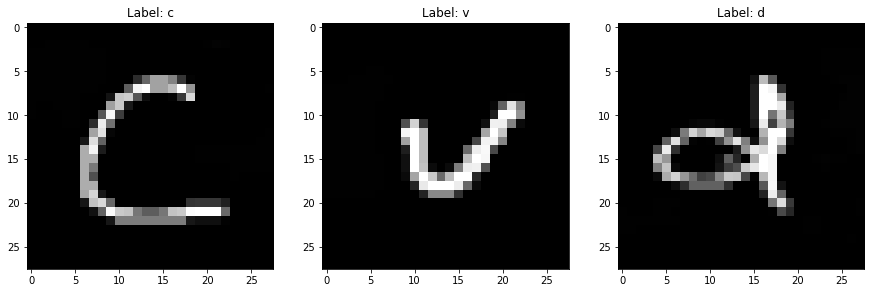

In [74]:
num_images = 3
fig,axes = plt.subplots(1,num_images,figsize=(15,10))
for image,label,ax in zip(X_train[:num_images],y_train[:num_images],axes):
    ax.imshow(image.reshape(28,28),cmap='gray',vmin=0,vmax=1.0)
    for i in range(len(label)):
        if(label[i]==1.0):
            lab=list(dict.keys())[list(dict.values()).index(i)]
    ax.set_title(f"Label: {lab}")

# Multilayer Perceptron


This image above represents schematically the conventional perceptron. Each input, represented as a multidimensional vector $\mathbf{x}=\{x_0=1,x_1,x_2,\ldots,x_n\}$, is multiplied by a set of weights $\mathbf{w} = \{w_0,w_1,w_2,\ldots,w_n\}$ to produce the weighted sum $$z = \sum_{i=0}^{n} x_i w_i$$. In the case of a vanilla perceptron, this weighted sum $z$ is lastly fed through as step function to produce the predicted output $a = \text{step}(z)$. This results in the output where $a=1$ if $z>0$ and $a=0$ if $z<0$.

With the output $a$ taking the value 0 or 1, this type of structure really only works for binary classification problems (i.e. situations where each input $\mathbf{x}$ has one of two intended labels: 0 or 1). The weights $\mathbf{w}$ in this context can be interpreted as assigning credence to the different inputs $x_i$ based on their relative importance. Notice, there is an additional constant $x_0=1$ concatenated to each input, frequently called the *bias term* or just *the bias*. 


These neural networks are often schematically represented with a series of nodes and arrows as shown on the right. Note, in our application to MNIST each input would be `784+1` dimensional (including the bias) and the output `26` dimensional for representing the one-hot encoded binary vector of output labels. Rather than restricting ourselves to treating each sum with a step function as in the vanilla perceptron, this concept is generalized to any arbitrary function typically called the *activation function*, depicted as $\sigma(\cdot)$ in the schematic. In principle almost any function may be an activation function, however people typically use one of the following activation functions due to some nice mathematical properties we will discuss later:

### Feed forward
Given a predefined neural network *architecture* (the *architecture* of a neural network refers to all the elements necessary to completely define the flow of data, which involve the number and size of hidden layers, which activation functions, the output size, etc.) the process of generating an output from an input is called a *forward* pass. As we shall see, for an MLP the forward pass may be succinctly represented as a series of matrix multiplications.

Consider the MLP represented schematically above with sigmoid activations $\sigma$ in the hidden layer. Each neuron in the hidden layers will be weighted sums of the inputs: $$a_j = \sigma(\sum_{i=1}^{784} x_i* w_{i,j})$$ for $j=\{1,2,\ldots,15\}$ (notice, there is no bias term in this example). From here it clear to see that the weights $w_{i,j}$ may be compacted into a matrix $W \in {\rm I\!R}^{784\times15}$ where $W_{i,j} = w_{i,j}$, allowing for all the neurons in the hidden layer to be efficiently calculated using matrix multiplication: $\mathbf{a}^{(1)} = \sigma(\mathbf{z}^{(1)}) = \sigma(\mathbf{x}W)$. Where $\mathbf{a}^{(i)},\mathbf{z}^{(i)} \in {\rm I\!R}^{1\times 15}$, with the superscript $(i)$ indicating the assocaited layer number, and $\mathbf{x} \in {\rm I\!R}^{1\times 784}$ are both arranged as column vectors. Another, different, weight matrix is needed to transform the hidden layer to the output layer. Let's demarcate these two as $W^{(1)}$ for the matrix which transforms the inputs to the hidden layer $\mathbf{a}^{(1)}$ and $W^{(2)} \in {\rm I\!R}^{15\times 10}$ for transforming the hidden layer to the output layer $\mathbf{z}^{(2)}$. Mathematically, $$\mathbf{z}^{(2)} = \sigma(\mathbf{x}W^{(1)})W^{(2)}$$. Notice, we've yet to treat this output $\mathbf{z}^{(2)}$ with an activation function.

The last step of process for classification tasks is actually producing a prediction from these numbers in the output layer $\mathbf{z}^{(2)}$. Typically, in the case of multi-label classification, this is done using a *softmax* activation function which effectively converts the output neurons into probabilities for each label. This has the mathematical form, $$\text{softmax}(\mathbf{z})_j = \frac{\exp(z_j)}{\sum_{k=0}^{K=9}\exp{(z_k)}}$$.


### Backpropagation
Now that we have an understanding of how an MLP generates outputs from inputs, we engage the problem of how to actually *train* this neural network. *Training* a neural network (in a supervised setting, which means each input comes with a known output) refers to the process of iteratively updating the weights of the network to improve it's performance. The performance of the neural network is evaluated using a *loss function* which quantitatively measures how "close" the neural network output is to the true output. In short, using *backpropagation* we aim to minimize the loss function with respect to the weights (also called *parameters*) of the neural network.     

# Multilayer perceptron: the code


## Feed forward

Implementing the forward pass of the neural network is relatively simply as everything is basically just a series of matrix multiplicaitons. The example we looked at when working through the math had a forward pass which mathematically took the form 
$\text{softmax}((\sigma(\mathbf{x}W^{(1)})W^{(2)}))$ .
We'll of course want to make things a bit more modular by allowing the user to choose some of the neural network paramters, such as the number of hidden layers `N_l` and the nunber of neurons per layer `L`. For simplicity we'll restrict that all the hidden layers are treated with sigmoid activaitons and the final layer processed with a softmax activation, which if you recall will be nessesary for us to ultimately purpose this MLP to make predictions.

We can start by simply defining our activation functions:

The inputs `x`, weight matricies `w`, and activations are in principle all we need to define the forward pass; however, for efficency reasons we'll want to store the outputs of the hidden layer neurons when performing the forward pass. Storing these values will help us later more quickly calculate the gradients during the backward pass. The `init_layers` functions will initalize these hidden layers as NumPy arrays, doing this before we begin training will help us save some overhead we would otherwise inccur reinitalizing these hidden layers before each forward pass. These hidden layer values will be stored in multi-dimensional matricies, called *tensors*. One dimension of these tensors will be the `batch size` which will indicate the number of samples simultaneously passed to MLP during one training loop (feed forward + backpropagation).

In order to perform a forward pass our input `x` is consequtively multiplied by weight matricies passed into the associated activaiton functions. The paramters in these weight matricies will ultimately be learned through backpropagation, but each weight matrix must first be initalized to random values. There are a number of different methods for doing this initalization, but for the moment we'll use a simple approach of just drawing the numerical values from a normal distribution with mean zero and standard deviation 1. We could have also reasonably choosen to simply draw from a uniform distribution on the range `[-1,1]` (why would it be wrong to initalize the weight matricies with all zeros?). 

Finally, we define the `feed_forward` function to iterate though the calculations to perform the forward pass.

## Backpropagation

Initalizing all the weights, layers, and activations prior to the forward pass makes much of the backward pass implimentation actually quite simple.

We define a `sigmoid_prime` function, which simply computes the derivative of the sigmoid activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass. Recall, $\sigma^{\prime}(x) = \sigma(x)(1-\sigma(x))$.

We define the `tanh_prime` function, which simply computes the derivative of the tanh activation $\sigma^{\prime}$. We'll use this when computing the gradients during the backward pass. Recall, $\sigma^{\prime}(x) = 1-\sigma(x)^2$.

## Training

The number of `epochs` we set defines the number of iterations we train our model. In each `epoch` a number of forward + backward pass are iteratively performed on mini-batches of data until our neural network has *seen* all the training data.


# Multilayer Perceptron: Code


In [75]:
class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(27)[Y.astype(int).reshape(-1)])
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(27)[Y_val.astype(int).reshape(-1)])
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes =np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        # VCompute the sigmoid
        return 1./(1.+np.exp(-x))

    def __tanh(self,x):
        return np.tanh(x)
    
    def __softmax(self,x):
        """
    Compute the softmax of `x`,

    Parameters
    ----------
    x : array_like
        (N x dim) array with N samples by p dimensions. dim=10 for MNIST classification. 

    Returns
    -------
    softmax(x) : float or array_like
        softmax applied to `x` along the first axis.
    """
        # Compute softmax along the rows of the input
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        # Compute the loss along the rows, averaging along the number of samples
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        # Compute the accuracy along the rows, averaging along the number of samples
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        # Compute the derivative of sigmoid where h=sigmoid(x)
        return h*(1-h)
    
    def __tanh_prime(self,h):
        return 1-h**2
    
    def __to_categorical(self,x):  
        # Transform probabilities into categorical predictions row-wise, by simply taking the max probability
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        # Initialize the weights of the network given the sizes of the layers
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        # Initialize and allocate arrays for the hidden layer activations 
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        """
    Perform a forward pass of the neural network.

    Parameters
    ----------
    batch : array_like
        (batch_size x dim) matrix of inputs
    hidden_layers : list
        List of hidden layer outputs
    weights : array_like
        Array of weight matricies
    
    Returns
    -------
    output : array_like
        Forward pass output of the MLP
    hidden_layers : array_like
        List of hidden layer outputs, populated from the forward pass.
    """
        # Perform a forward pass of `batch` samples (N_samples x N_features)
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__tanh(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        delta_t = (self.__out - batch_y)*self.__tanh_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__tanh_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
        """
        Calculate derivative of sigmoid activation based on sigmoid output.

        Parameters
        ----------
        output : array_like
            Forward pass output of the MLP
        batch_y : array_like
            True labels for the samples in the batch
        hidden_layers : list
            List of hidden layer outputs  
        weights : array_like
            Array of weight matricies
        lr : float
            Learning rate for SGD
        batch_size : int
            Size of a training mini-batch

        Returns
        -------
        weights : array_like
            Array of weight matricies, updated from the backpropagation.
    
        """
        # Update the weights of the network through back-propagation

            
    def predict(self,X):
        # Generate a categorical, one-hot, prediction given an input X
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        # Evaluate the performance (accuracy) predicting on X with true labels Y
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        # Train the model with a given batch size, epochs, and learning rate. Store and print relevant metrics.
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")
    

Great, now let's give this a try. Let's create a really simple MLP with only a single hidden layer `L=1` with 128 neurons `N_l=256`. We'll train with a `batch_size=50` for `epochs=100` and a learning rate `lr=0.8`.

In [76]:
model = MLP(X_train,Y_train,X_test,Y_test,L=1,N_l=256)
model.train(batch_size=50,epochs=100,lr=0.8)

C:\Users\Soustab\AppData\Local\Temp\ipykernel_12828\2763534016.py:72: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.weights = np.asarray(self.weights)


Epoch 1: loss = 3.335 | acc = 0.091 | val_loss = 3.099 | val_acc = 0.133 | train_time = 0.551 | tot_time = 0.564
Epoch 2: loss = 2.856 | acc = 0.188 | val_loss = 2.747 | val_acc = 0.262 | train_time = 0.449 | tot_time = 0.463
Epoch 3: loss = 2.528 | acc = 0.324 | val_loss = 2.562 | val_acc = 0.357 | train_time = 0.448 | tot_time = 0.461
Epoch 4: loss = 2.34 | acc = 0.415 | val_loss = 2.483 | val_acc = 0.379 | train_time = 0.388 | tot_time = 0.401
Epoch 5: loss = 2.223 | acc = 0.479 | val_loss = 2.446 | val_acc = 0.412 | train_time = 0.405 | tot_time = 0.419
Epoch 6: loss = 2.149 | acc = 0.521 | val_loss = 2.42 | val_acc = 0.446 | train_time = 0.411 | tot_time = 0.424
Epoch 7: loss = 2.098 | acc = 0.553 | val_loss = 2.397 | val_acc = 0.452 | train_time = 0.421 | tot_time = 0.435
Epoch 8: loss = 2.054 | acc = 0.576 | val_loss = 2.392 | val_acc = 0.47 | train_time = 0.392 | tot_time = 0.405
Epoch 9: loss = 2.023 | acc = 0.597 | val_loss = 2.388 | val_acc = 0.47 | train_time = 0.405 | tot_

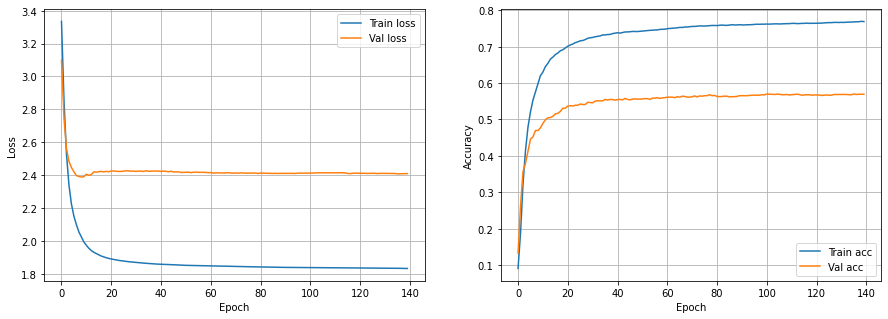

In [78]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(model.train_loss,label="Train loss")
ax[0].plot(model.val_loss,label="Val loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(model.train_acc,label="Train acc")
ax[1].plot(model.val_acc,label="Val acc")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [79]:
model.evaluate(X_test,y_test)

0.5694070080862533

### F1 Score, Recall, and Precision:

Precision is the ratio of true positives to the total number of predicted positives. It measures how many of the predicted positive cases are actually positive. A high precision score indicates that the model is good at predicting positive cases.

Recall is the ratio of true positives to the total number of actual positives. It measures how many of the actual positive cases are correctly predicted by the model. A high recall score indicates that the model is good at identifying positive cases.

F1 Score is the harmonic mean of precision and recall. It is a single score that balances both precision and recall. A high F1 score indicates that the model is good at both identifying positive cases and avoiding false positives.

In [80]:
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred=model.predict(X_test)
y_pred=(np.argmax(y_pred, axis=1)+1).reshape(-1, 1).flatten()
y_test_c=(np.argmax(y_test, axis=1)+1).reshape(-1, 1).flatten()
# print(y_test_c)
print ('F1 score:', f1_score(y_test_c, y_pred,average='weighted'))
print ('Recall:', recall_score(y_test_c, y_pred,average='weighted'))
print ('Precision:', precision_score(y_test_c, y_pred,average='weighted'))

F1 score: 0.5587620254107325
Recall: 0.5694070080862533
Precision: 0.5543389396341125
